In [1]:
from typing import *

def f(li: List[int]) -> bool:
    """
    Find a list integers containing exactly three distinct values, such that no integer repeats
    twice consecutively among the first eleven entries. (So the list needs to have length greater than ten.)
    """
    return all([li[i] != li[i + 1] for i in range(10)]) and len(set(li)) == 3
def g():
    return [1, 2, 3] * 100

assert f(g()) == True


In [41]:
%load_ext autoreload
%autoreload 2
import os
os.environ['TRANSFORMERS_CACHE'] = "/media/data/flowers/OpenELM/models"
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np
import json 
from openelm.environments.p3 import skill_list,P3_probsol_chat_med_seed
import pickle
from tqdm import tqdm
from langchain.schema import HumanMessage
from transformers import pipeline

# model_id= "Salesforce/codet5p-110m-embedding"
# tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_id, trust_remote_code=True,device_map="auto")
model = None
tokenizer =None

def getallitems(maps):
    """
    Returns all the phenotypes that are in the Map."""
    genomes = maps["genomes"]
    valid_phenotype=[]
    for gen in np.ndindex(genomes.shape):
        value_gen = type(genomes[gen])
        if value_gen!=float and value_gen!=int:
            valid_phenotype.append(genomes[gen])

    return valid_phenotype



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /media/data/flowers/conda/envs/codegpt/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


In [8]:
rd_gen="/media/data/flowers/OpenELM/run_saved/random_gen/step_399_1/"
elm="/media/data/flowers/OpenELM/run_saved/elm/step_399_1/"
path_centroids= "/media/data/flowers/OpenELM/run_saved/elm/step_399_1/centroids.npy"
elm_NLP="/media/data/flowers/OpenELM/run_saved/elm_nlp/step_399_1/"
imgep_smart="/media/data/flowers/OpenELM/run_saved/imgep_smart/step_399_1/"
imgep_random="/media/data/flowers/OpenELM/run_saved/imgep_random/step_399_1/"
full_list_path_seed1=[rd_gen,elm,elm_NLP,imgep_smart,imgep_random]
list_legend = ["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]

In [2]:
# list_few_shot_example= ["def f(a):return a\ndef g(): return 1","def f(a):return a\ndef g(): return 2","def f(a):return a\ndef g(): return 3"]
# code_batch = ["def f(li: List[int]) -> bool:\n    \"\"\"Find a list integers such that the integer i occurs i times, for i = 0, 1, 2, ..., 9.\"\"\"\n    return all([li.count(i) == i for i in range(10)])\ndef g():\n    return [i for i in range(10) for j in range(i)]\nassert f(g())"]
# print(P3_probsol_chat_med_seed(list_few_shot_example, code_batch))

In [2]:
# 67=308
price_b0=8 # random
price_b1=8 # ELM
price_b2=10.5 # ELM + NLP space
price_b3= 16 # dumb IMGEP
price_b4 = 16 # smart IMGEP
n_expe=4
ratio=400/300
(price_b0+price_b1+price_b2+price_b3+price_b4)*n_expe*ratio

312.0

In [3]:
# # IMGEP smart
# # seed = 42
# # expe 1 
# imgep_smart = "/media/data/flowers/OpenELM/logs/elm/23-08-26_15:17/step_399/save_all.json"# 20 #"/media/data/flowers/OpenELM/logs/elm/23-08-25_11:24/step_299/save_all.json" # 15$

# # imgep random
# # expe 1
# imgep_random ="/media/data/flowers/OpenELM/logs/elm/23-08-26_17:12/step_399/save_all.json"# 20$ "/media/data/flowers/OpenELM/logs/elm/23-08-25_19:57/step_299/save_all.json" # 15$
# # ELM-NLP
# elm_NLP ="/media/data/flowers/OpenELM/logs/elm/23-08-26_18:51/step_399/save_all.json"# 20$"/media/data/flowers/OpenELM/logs/elm/23-08-26_01:02/step_299/save_all.json" # 10.50$
# # ELM-base
# elm_base="" # 9$
# # Random gen 
# rd_gen = "/media/data/flowers/OpenELM/logs/elm/23-08-26_11:55/step_399/save_all.json" # 10.24$ for 400 start at 41.08 to 51,32

# path_centroids= "/media/data/flowers/OpenELM/logs/elm/23-08-27_14:15/step_399/centroids.npy"
# elm="/media/data/flowers/OpenELM/logs/elm/23-08-27_14:15/step_399/"

# niched filled analysis

## utils

In [ ]:


# init maps
def return_cells_filled_per_gen_map_elite(path_save_all,max_gen=-1,include_trainset=False,include_full_trainset=False):
    #_init_discretization():
    n_skills=10
    behavior_space= np.repeat([[0, 1]], n_skills, axis=0).T

    bins = np.linspace(*behavior_space,  3)[1:-1].T  # type: ignore
    # bins
    def to_mapindex(b, bins=bins) :
        """Converts a phenotype (position in behaviour space) to a map index."""
        return (
            None
            if b is None
            else tuple(np.digitize(x, bins) for x, bins in zip(b, bins))
        )
        

    path_maps = path_save_all.split("save_all.json")[0]+"maps.pkl"

    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    items_trainset = [item for item in allitems if item.idx_generation==-1]
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    if "/elm/" in path_save_all:
        elm_phenotype = path_save_all.split("maps.pkl")[0]+"_phenotype.npy"
        phen= np.load(elm_phenotype)
        for i in range(len(items_gen)):
            items_gen[i].emb=phen[i]
    print(len(items_gen))
    
    nonzero=np.zeros(shape=[2]*n_skills,dtype=bool)#np.zeros_like(maps["nonzero"]) 
    # list_map_ix_train=[to_mapindex(puzz.emb) for puzz in items_trainset]
    if include_full_trainset:
        path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
        with open(path_trainset, "r") as f:
            list_puzzle_full_trainset = json.load(f)
            list_map_ix_train=[to_mapindex(puzz["emb"]) for puzz in list_puzzle_full_trainset]
            for map_ix_train in list_map_ix_train:
                nonzero[map_ix_train] = True
    # elif include_trainset:
    #     for map_ix_train in list_map_ix_train:
    #         nonzero[map_ix_train] = True

    # separate items per generation
    list_gens= [puzz.idx_generation for puzz in items_gen]
    if max_gen==-1:
        max_gen = max(list_gens)
    
    list_emb_per_idx_gen = [[] for _ in range(max_gen+1)]
    for i, gen in enumerate(list_gens):
        if gen<len(list_emb_per_idx_gen):
            list_emb_per_idx_gen[gen].append(items_gen[i].emb)
        
    number_of_cells_filled=[nonzero.sum()]
    for i in range(len(list_emb_per_idx_gen)):
        for puzz_emb in list_emb_per_idx_gen[i]:
            new_map_ix=to_mapindex(puzz_emb)
            nonzero[new_map_ix] = True
        number_of_cells_filled.append(nonzero.sum())
    return number_of_cells_filled



def return_cells_filled_in_embspace_from_NLPembspace(path_save_all,path_centroids,centroids=None,max_gen=-1,include_trainset=False,include_full_trainset=False,model=model,tokenizer=tokenizer,pipeline=None):
    #_init_discretization():
    if centroids is None:
        centroids=np.load(path_centroids)
    # bins
    def to_mapindex(b,centroids=centroids):
        """Maps a phenotype (position in behaviour space) to the index of the closest centroid."""
        return (
            None
            if b is None
            else (np.argmin(np.linalg.norm(b - centroids, axis=1)),)
        )
        
    path_maps_cvt = path_centroids.split("centroids.npy")[0]+"maps.pkl"
    path_maps = path_save_all.split("save_all.json")[0]+"maps.pkl"

    with open(path_maps_cvt, "rb") as f:
        maps_cvt = pickle.load(f)
    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    with torch.no_grad():
        for i in tqdm(range(len(allitems))):
            program_str=allitems[i].program_str
            if pipeline is None:
                inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
                emb = model(inputs.to("cuda"))[0]
                allitems[i].emb=emb.to("cpu").numpy()
            else:
                features = np.array(pipeline(program_str))
                allitems[i].emb=features.mean(axis=1).flatten()
    items_trainset = [item for item in allitems if item.idx_generation==-1]
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    

            
    print(len(items_gen))
    


    nonzero=np.zeros_like(maps_cvt["nonzero"]) 
    list_map_ix_train=[to_mapindex(puzz.emb) for puzz in items_trainset]
    
    if include_full_trainset:
        path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
        with open(path_trainset, "r") as f:
            list_puzzle_full_trainset = json.load(f)
            # list_puzzle_full_trainset["program_str"]
        with torch.no_grad():
            for i in tqdm(range(len(list_puzzle_full_trainset))):
                program_str=list_puzzle_full_trainset[i]["program_str"]
                if pipeline is None:
                    inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
                    emb = model(inputs.to("cuda"))[0]
                    emb=emb.to("cpu").numpy()
                else:
                    features = np.array(pipeline(program_str))
                    emb=features.mean(axis=1).flatten()
                list_puzzle_full_trainset[i]["emb"]=emb
        list_map_ix_train=[to_mapindex(puzz["emb"]) for puzz in list_puzzle_full_trainset]
        for map_ix_train in list_map_ix_train:
            nonzero[map_ix_train] = True
              
    elif include_trainset:
        for map_ix_train in list_map_ix_train:
            nonzero[map_ix_train] = True

    # separate items per generation
    list_gens= [puzz.idx_generation for puzz in items_gen]
    if max_gen==-1:
        max_gen = max(list_gens)
    
    list_emb_per_idx_gen = [[] for _ in range(max_gen+1)]
    for i, gen in enumerate(list_gens):
        if gen<len(list_emb_per_idx_gen):
            list_emb_per_idx_gen[gen].append(items_gen[i].emb)
        
    number_of_cells_filled=[nonzero.sum()]
    for i in range(len(list_emb_per_idx_gen)):
        for puzz_emb in list_emb_per_idx_gen[i]:
            new_map_ix=to_mapindex(puzz_emb)
            nonzero[new_map_ix] = True
        number_of_cells_filled.append(nonzero.sum())
    return number_of_cells_filled



## NLP space

1258
2496
1733
2015
1896


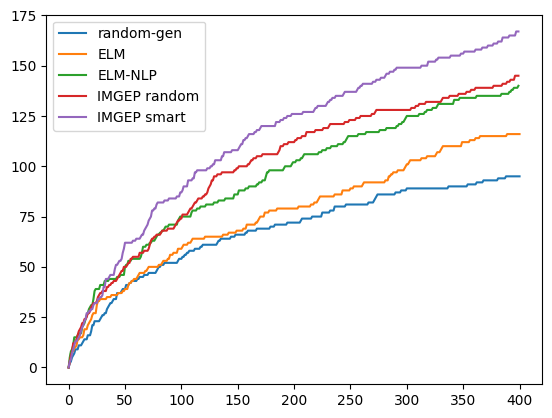

In [5]:
include_trainset=False


#plo
number_of_cells_filled_b0=return_cells_filled_per_gen_map_elite(rd_gen,include_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b1=return_cells_filled_per_gen_map_elite(elm,include_trainset=include_trainset)#,max_gen=300)

number_of_cells_filled_b2=return_cells_filled_per_gen_map_elite(elm_NLP,include_trainset=include_trainset)#,max_gen=300)
idx_m=-1#len(number_of_cells_filled_b2)+100
number_of_cells_filled_b3=return_cells_filled_per_gen_map_elite(imgep_random,include_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b4=return_cells_filled_per_gen_map_elite(imgep_smart,include_trainset=include_trainset)#,max_gen=300)
plt.plot(number_of_cells_filled_b0)
plt.plot(number_of_cells_filled_b1)

plt.plot(number_of_cells_filled_b2[:idx_m])
plt.plot(number_of_cells_filled_b3[:idx_m])
plt.plot(number_of_cells_filled_b4[:idx_m])
plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])

1258
2496
1733
2015
1896


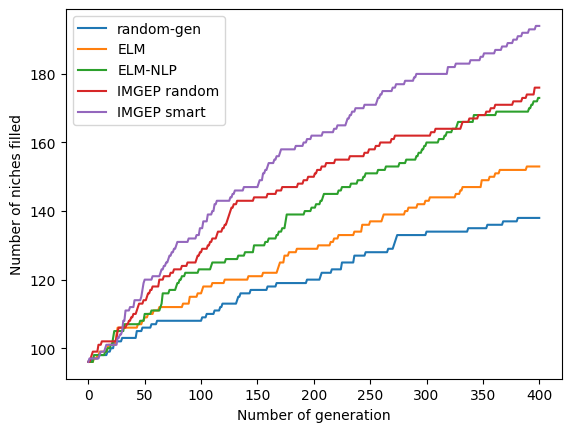

In [7]:
include_trainset=True

number_of_cells_filled_b0=return_cells_filled_per_gen_map_elite(rd_gen,include_full_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b1=return_cells_filled_per_gen_map_elite(elm,include_full_trainset=include_trainset)#,max_gen=300)

number_of_cells_filled_b2=return_cells_filled_per_gen_map_elite(elm_NLP,include_full_trainset=include_trainset)#,max_gen=300)
idx_m=-1#len(number_of_cells_filled_b2)+100
number_of_cells_filled_b3=return_cells_filled_per_gen_map_elite(imgep_random,include_full_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b4=return_cells_filled_per_gen_map_elite(imgep_smart,include_full_trainset=include_trainset)#,max_gen=300)
plt.plot(number_of_cells_filled_b0)
plt.plot(number_of_cells_filled_b1)

plt.plot(number_of_cells_filled_b2)
plt.plot(number_of_cells_filled_b3)
plt.plot(number_of_cells_filled_b4)
plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")
plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])

## emb space

100%|██████████| 1577/1577 [00:13<00:00, 118.61it/s]


319 1258


100%|██████████| 3028/3028 [00:24<00:00, 123.36it/s]


532 2496


100%|██████████| 2079/2079 [00:18<00:00, 109.80it/s]


346 1733


100%|██████████| 2396/2396 [00:28<00:00, 85.24it/s]


381 2015


100%|██████████| 2301/2301 [00:27<00:00, 82.37it/s]


405 1896


100%|██████████| 536/536 [00:05<00:00, 100.27it/s]


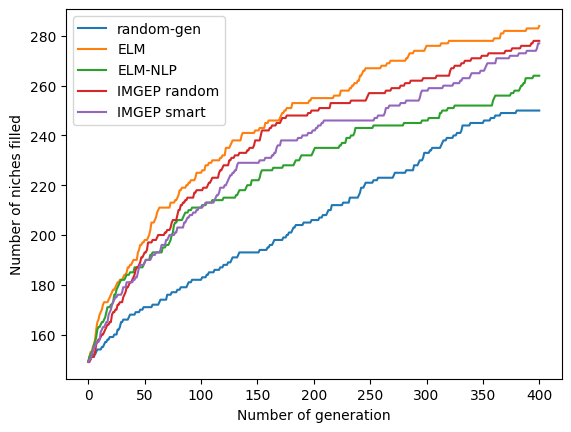

In [11]:
include_full_trainset=True
number_of_cvt_cells_filled_b0=return_cells_filled_in_embspace_from_NLPembspace(rd_gen,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b1=return_cells_filled_in_embspace_from_NLPembspace(elm,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b2=return_cells_filled_in_embspace_from_NLPembspace(elm_NLP,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b3=return_cells_filled_in_embspace_from_NLPembspace(imgep_random,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b4=return_cells_filled_in_embspace_from_NLPembspace(imgep_smart,path_centroids,include_full_trainset=include_full_trainset)

plt.plot(number_of_cvt_cells_filled_b0)
plt.plot(number_of_cvt_cells_filled_b1)
plt.plot(number_of_cvt_cells_filled_b2)
plt.plot(number_of_cvt_cells_filled_b3)
plt.plot(number_of_cvt_cells_filled_b4)
plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")
plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])

## other embeddings model

In [4]:
from transformers import BitsAndBytesConfig
quantization_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_compute_dtype=torch.float16
)
embedding_model_path = "Salesforce/codegen-350M-mono"#"Salesforce/codegen2-1B" #"flax-sentence-embeddings/st-codesearch-distilroberta-base"#"Salesforce/codegen-350M-mono"
pl = pipeline("feature-extraction", model=embedding_model_path,device_map="auto",trust_remote_code=True,
              quantization_config=quantization_config
              )

model_id= "Salesforce/codet5p-110m-embedding"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModel.from_pretrained(model_id, trust_remote_code=True,device_map="auto",quantization_config=quantization_config)
inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
emb = model(inputs.to("cuda"))[0]
emb=emb.to("cpu").numpy()


## model without pipeline

100%|██████████| 1577/1577 [00:21<00:00, 73.27it/s]


1258


100%|██████████| 3028/3028 [00:41<00:00, 72.53it/s]


2496


100%|██████████| 2079/2079 [00:29<00:00, 70.18it/s]


1733


100%|██████████| 2396/2396 [00:34<00:00, 70.41it/s]


2015


100%|██████████| 2301/2301 [00:31<00:00, 71.92it/s]


1896


100%|██████████| 536/536 [00:07<00:00, 71.16it/s]


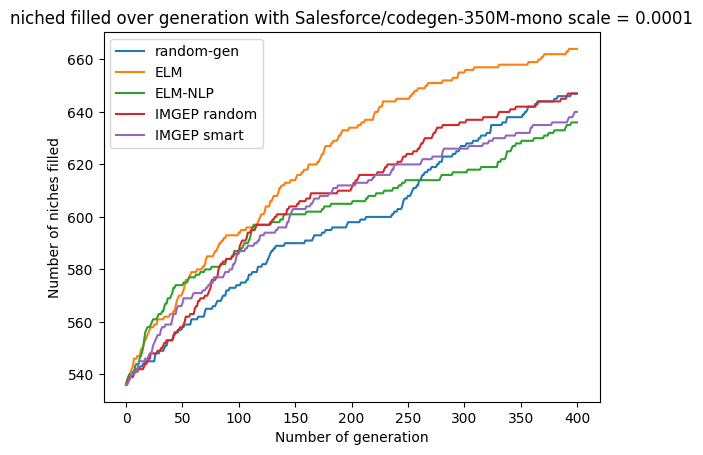

100%|██████████| 1577/1577 [00:20<00:00, 75.62it/s]


1258


100%|██████████| 3028/3028 [00:40<00:00, 75.25it/s]


2496


100%|██████████| 2079/2079 [00:27<00:00, 74.43it/s]


1733


100%|██████████| 2396/2396 [00:32<00:00, 73.87it/s]


2015


100%|██████████| 2301/2301 [00:31<00:00, 73.10it/s]


1896


100%|██████████| 536/536 [00:07<00:00, 73.64it/s]


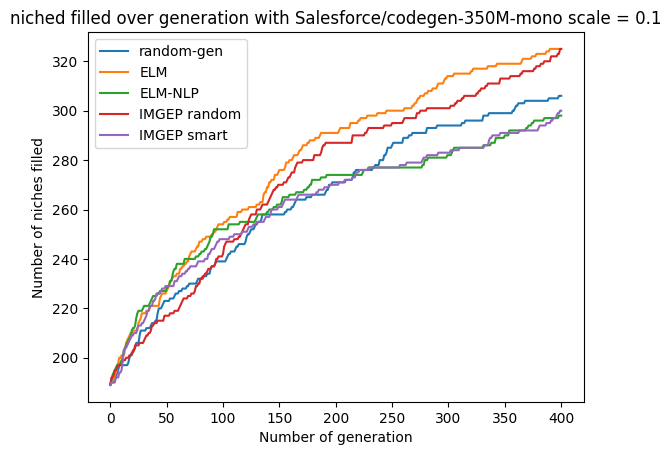

100%|██████████| 1577/1577 [00:21<00:00, 74.71it/s]


1258


100%|██████████| 3028/3028 [00:40<00:00, 74.73it/s]


2496


100%|██████████| 2079/2079 [00:28<00:00, 74.25it/s]


1733


100%|██████████| 2396/2396 [00:32<00:00, 72.77it/s]


2015


100%|██████████| 2301/2301 [00:31<00:00, 73.34it/s]


1896


100%|██████████| 536/536 [00:07<00:00, 74.25it/s]


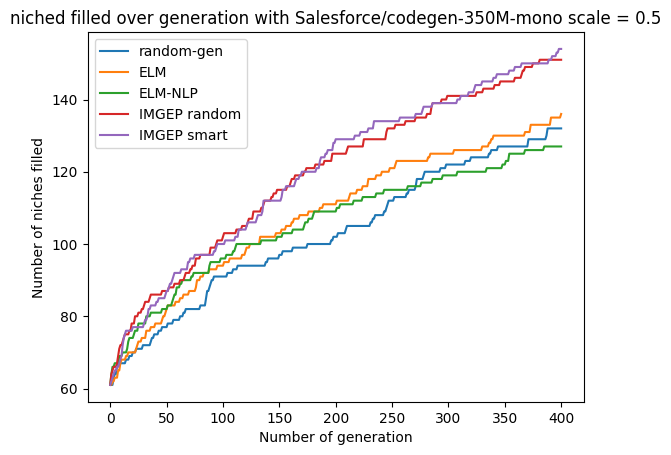

100%|██████████| 1577/1577 [00:21<00:00, 74.83it/s]


1258


100%|██████████| 3028/3028 [00:40<00:00, 75.41it/s]


2496


100%|██████████| 2079/2079 [00:28<00:00, 73.86it/s]


1733


100%|██████████| 2396/2396 [00:32<00:00, 73.25it/s]


2015


100%|██████████| 2301/2301 [00:31<00:00, 73.21it/s]


1896


100%|██████████| 536/536 [00:06<00:00, 78.72it/s]


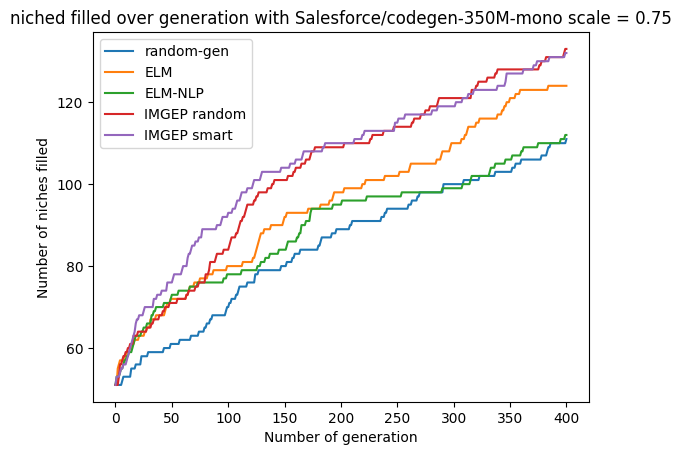

100%|██████████| 1577/1577 [00:19<00:00, 80.33it/s]


1258


100%|██████████| 3028/3028 [00:37<00:00, 80.43it/s]


2496


100%|██████████| 2079/2079 [00:26<00:00, 79.93it/s]


1733


100%|██████████| 2396/2396 [00:30<00:00, 78.03it/s]


2015


100%|██████████| 2301/2301 [00:29<00:00, 77.93it/s]


1896


100%|██████████| 536/536 [00:06<00:00, 78.08it/s]


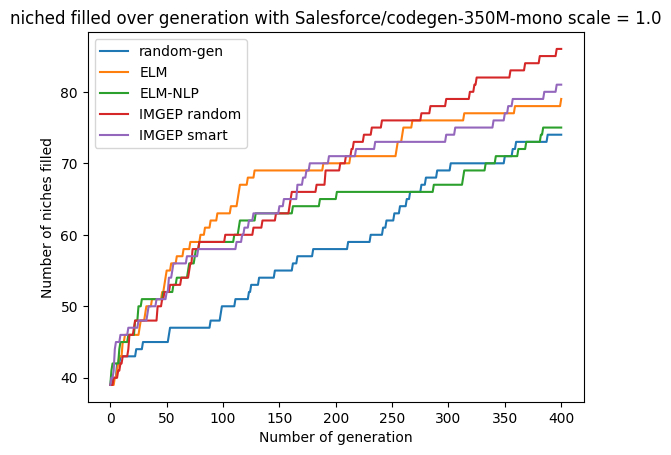

100%|██████████| 5/5 [16:40<00:00, 200.19s/it]


In [5]:
from sklearn.cluster import KMeans
list_emb_cod5p=[]
path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
list_emb=[]
with open(path_trainset, "r") as f:
    list_puzzle_full_trainset = json.load(f)
    # list_puzzle_full_trainset["program_str"]
with torch.no_grad():
    for i in tqdm(range(len(list_puzzle_full_trainset))):
        program_str=list_puzzle_full_trainset[i]["program_str"]
        inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
        emb = model(inputs.to("cuda"))[0]
        emb=emb.to("cpu").numpy()
        # emb=features.mean(axis=1).flatten()
        list_emb.append(emb)
list_emb=np.array(list_emb)
n_vect2add= 42_000 #- len(list_emb)

liste_choice=np.random.choice(len(list_emb), n_vect2add,replace= True)
embed2nois = list_emb[liste_choice]
scale=0.5
noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
noisy_embed = embed2nois + noise  # add noise to embeddings
noisy_embed = noisy_em█
for scale in tqdm([1e-4,0.1,0.5,0.75,1.]):
    noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
    noisy_embed = embed2nois + noise  # add noise to embeddings
    noisy_embed = noisy_embed / np.linalg.norm(noisy_embed, axis=1)[:, np.newaxis] # normalize embeddings
    points = noisy_embed
    # points = np.vstack((list_emb,noisy_embed))

    k_means = KMeans(init="k-means++", n_init="auto", n_clusters=1024,random_state=42)
    k_means.fit(points)
    centroids = k_means.cluster_centers_
    include_full_trainset=True
    number_of_cvt_cells_filled_b0=return_cells_filled_in_embspace_from_NLPembspace(
        rd_gen,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b1=return_cells_filled_in_embspace_from_NLPembspace(
        elm,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b2=return_cells_filled_in_embspace_from_NLPembspace(
        elm_NLP,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b3=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_random,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    number_of_cvt_cells_filled_b4=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_smart,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,model=model,tokenizer=tokenizer)#,pipeline=pl)
    list_emb_cod5p.append([number_of_cvt_cells_filled_b0,number_of_cvt_cells_filled_b1,number_of_cvt_cells_filled_b2,number_of_cvt_cells_filled_b3,number_of_cvt_cells_filled_b4])
    plt.plot(number_of_cvt_cells_filled_b0)
    plt.plot(number_of_cvt_cells_filled_b1)
    plt.plot(number_of_cvt_cells_filled_b2)
    plt.plot(number_of_cvt_cells_filled_b3)
    plt.plot(number_of_cvt_cells_filled_b4)
    plt.ylabel("Number of niches filled")
    plt.xlabel("Number of generation")
    plt.legend(["ELM", "IMGEP smart"])

    plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])
    plt.title(f"niched filled over generation with {embedding_model_path} scale = {scale}")
    plt.show()

### model with pipeline

  0%|          | 0/536 [00:00<?, ?it/s]/media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  0%|          | 0/4 [00:00<?, ?it/s]/media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3028/3028 [02:28<00:00, 20.36it/s]


2496


100%|██████████| 2396/2396 [02:38<00:00, 15.11it/s]


2015


100%|██████████| 2301/2301 [02:41<00:00, 14.24it/s]


1896


100%|██████████| 536/536 [00:32<00:00, 16.71it/s]


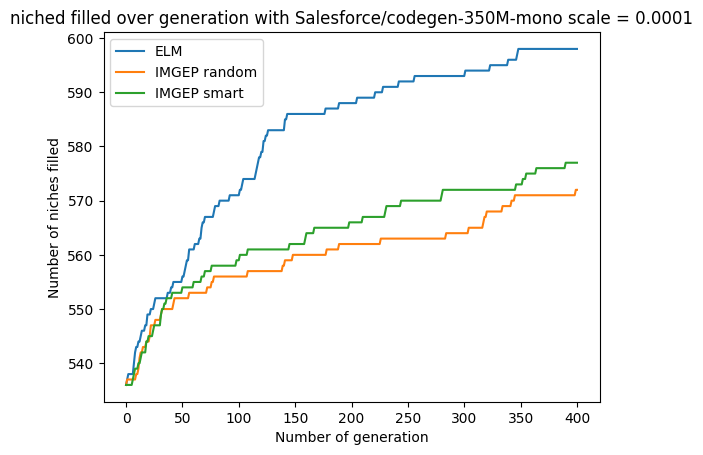

 25%|██▌       | 1/4 [10:16<30:49, 616.43s/it]/media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3028/3028 [02:24<00:00, 20.93it/s]


2496


100%|██████████| 2396/2396 [02:29<00:00, 15.98it/s]


2015


100%|██████████| 2301/2301 [02:41<00:00, 14.24it/s]


1896


100%|██████████| 536/536 [00:33<00:00, 16.02it/s]


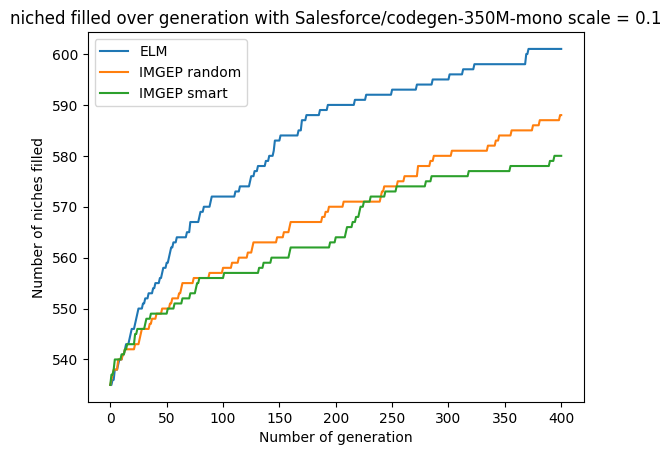

 50%|█████     | 2/4 [20:17<20:15, 607.65s/it]/media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3028/3028 [02:32<00:00, 19.81it/s]


2496


100%|██████████| 2396/2396 [02:42<00:00, 14.79it/s]


2015


100%|██████████| 2301/2301 [02:39<00:00, 14.41it/s]


1896


100%|██████████| 536/536 [00:32<00:00, 16.59it/s]


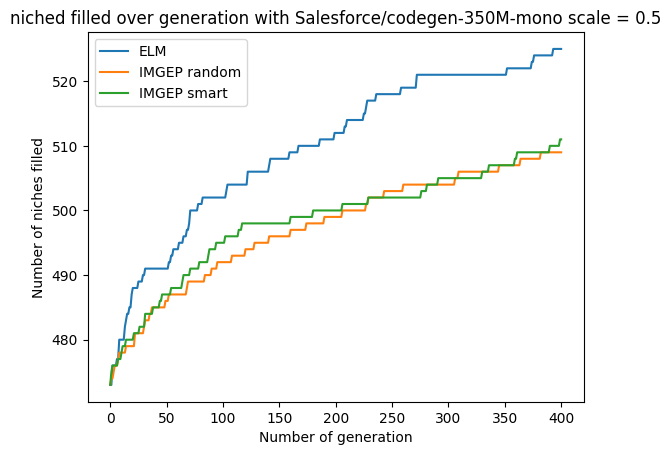

 75%|███████▌  | 3/4 [30:44<10:16, 616.17s/it]/media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/transformers/pipelines/base.py:1083: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 3028/3028 [02:21<00:00, 21.35it/s]


2496


100%|██████████| 2396/2396 [02:22<00:00, 16.76it/s]


2015


100%|██████████| 2301/2301 [02:23<00:00, 16.08it/s]


1896


100%|██████████| 536/536 [00:28<00:00, 18.76it/s]


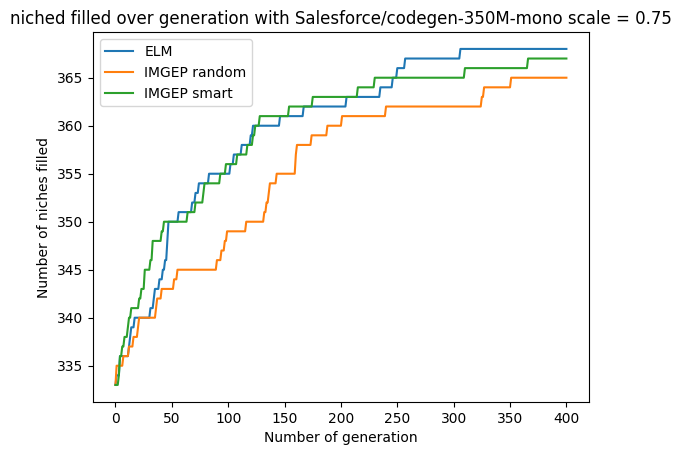

100%|██████████| 4/4 [40:10<00:00, 602.70s/it]


In [17]:
from sklearn.cluster import KMeans

path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
list_emb=[]
with open(path_trainset, "r") as f:
    list_puzzle_full_trainset = json.load(f)
    # list_puzzle_full_trainset["program_str"]
with torch.no_grad():
    for i in tqdm(range(len(list_puzzle_full_trainset))):
        program_str=list_puzzle_full_trainset[i]["program_str"]

        features = np.array(pl(program_str))
        emb=features.mean(axis=1).flatten()
        list_emb.append(emb)
list_emb=np.array(list_emb)
n_vect2add= 42_000 #- len(list_emb)

liste_choice=np.random.choice(len(list_emb), n_vect2add,replace= True)
embed2nois = list_emb[liste_choice]
scale=0.5
noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
noisy_embed = embed2nois + noise  # add noise to embeddings
noisy_embed = noisy_embed / np.linalg.norm(noisy_embed, axis=1)[:, np.newaxis] # normalize embeddings
points = noisy_embed
list_emb_codegen=[]
for scale in tqdm([1e-4,0.1,0.5,0.75]):
    noise = np.random.normal(loc=0.0, scale=scale,size=(embed2nois.shape[0],embed2nois.shape[1]))
    noisy_embed = embed2nois + noise  # add noise to embeddings
    noisy_embed = noisy_embed / np.linalg.norm(noisy_embed, axis=1)[:, np.newaxis] # normalize embeddings
    points = noisy_embed
    # points = np.vstack((list_emb,noisy_embed))

    k_means = KMeans(init="k-means++", n_init="auto", n_clusters=1024,random_state=42)
    k_means.fit(points)
    centroids = k_means.cluster_centers_
    include_full_trainset=True
    # number_of_cvt_cells_filled_b0=return_cells_filled_in_embspace_from_NLPembspace(
    #     rd_gen,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,pipeline=pl)
    number_of_cvt_cells_filled_b1=return_cells_filled_in_embspace_from_NLPembspace(
        elm,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,pipeline=pl)
    # number_of_cvt_cells_filled_b2=return_cells_filled_in_embspace_from_NLPembspace(
    #     elm_NLP,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,pipeline=pl)
    number_of_cvt_cells_filled_b3=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_random,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,pipeline=pl)
    number_of_cvt_cells_filled_b4=return_cells_filled_in_embspace_from_NLPembspace(
        imgep_smart,path_centroids,include_full_trainset=include_full_trainset,centroids=centroids,pipeline=pl)
    list_emb_codegen.append([number_of_cvt_cells_filled_b0,number_of_cvt_cells_filled_b1,number_of_cvt_cells_filled_b2,number_of_cvt_cells_filled_b3,number_of_cvt_cells_filled_b4])
    # plt.plot(number_of_cvt_cells_filled_b0)
    plt.plot(number_of_cvt_cells_filled_b1)
    # plt.plot(number_of_cvt_cells_filled_b2)
    plt.plot(number_of_cvt_cells_filled_b3)
    plt.plot(number_of_cvt_cells_filled_b4)
    plt.ylabel("Number of niches filled")
    plt.xlabel("Number of generation")
    plt.legend(["ELM","IMGEP random", "IMGEP smart"])

    # plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])
    plt.title(f"niched filled over generation with {embedding_model_path} scale = {scale}")
    plt.show()

## number of example generated / generation

Text(0.5, 1.0, 'evolution of the number of correct puzzle generated ')

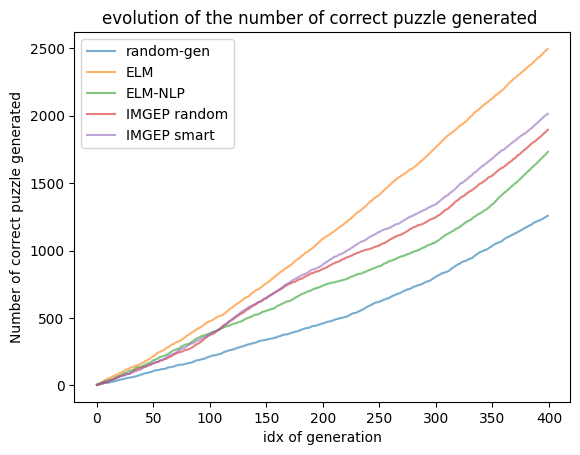

In [61]:
path_map ="/media/data/flowers/OpenELM/run_saved/elm/step_399_1/maps.pkl"
with open(path_map, "rb") as f:
    maps = pickle.load(f)
    
all_item=getallitems(maps)
idx_max=400
idx=[i for i in range(idx_max)]
for path_map in full_list_path_seed1:
    with open(path_map+"/maps.pkl", "rb") as f:
        maps = pickle.load(f)
    all_item=getallitems(maps)
    list_gen=[puzz.idx_generation for puzz in all_item] 
    count_item_gen=[list_gen.count(i) for i in range(idx_max)]
    evolution_numb_puzz = np.cumsum(count_item_gen)
    plt.plot(idx,evolution_numb_puzz,alpha=0.6)
plt.legend(list_legend)
plt.xlabel("idx of generation")
plt.ylabel("Number of correct puzzle generated")
plt.title('evolution of the number of correct puzzle generated ')

# diversity measure

## distance nearest neighb

In [23]:
from transformers import BitsAndBytesConfig
from tqdm import tqdm
quantization_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_compute_dtype=torch.float16
)
model_id = "Salesforce/codet5p-110m-embedding"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModel.from_pretrained(model_id, trust_remote_code=True,device_map="auto",quantization_config=quantization_config)
# model=torch.compile(model)

In [24]:
with torch.no_grad():
    full_list_path_seed1=[rd_gen,elm,elm_NLP,imgep_smart,imgep_random]
    list_legend = ["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"]
    all_items_gen=[]
    for path in full_list_path_seed1:
        path_maps = path + "maps.pkl"
        with open(path_maps, "rb") as f:
            maps = pickle.load(f)
        allitems=getallitems(maps)
        items_gen = [item for item in allitems if item.idx_generation!=-1]
        for puzz in tqdm(items_gen):
            inputs = tokenizer.encode(puzz.program_str, return_tensors="pt",truncation=True,max_length=512)
            emb = model(inputs.to("cuda"))[0]
            emb = emb.to("cpu").numpy()
            puzz.emb = emb
        all_items_gen.append(items_gen)
    
    
path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
with open(path_trainset, "r") as f:
    list_puzzle_full_trainset = json.load(f)
    # list_puzzle_full_trainset["program_str"]
list_emb_trainset=[]
with torch.no_grad():
    for i in tqdm(range(len(list_puzzle_full_trainset))):
        program_str=list_puzzle_full_trainset[i]["program_str"]
        inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
        emb = model(inputs.to("cuda"))[0]
        emb=emb.to("cpu").numpy()
        list_emb_trainset.append(emb)

100%|██████████| 536/536 [00:07<00:00, 68.81it/s]


In [71]:
k=1
for idx_baseline in range(len(full_list_path_seed1)):
    items_gen=[all_items_gen[idx_baseline][idx].emb for idx in range(len(all_items_gen[0]))]
    items_gen= torch.tensor(items_gen).to("cuda")
    dist_matr =torch.cdist(items_gen, items_gen, p=2.0)
    sum_values=0.
    for idx_ in range(dist_matr.shape[0]):
        values,_=torch.topk(dist_matr[idx_,:], 1+k,largest=False)
        values=values[1:].mean().item() #removed dist with itself
        sum_values+=values
    print("\nbaseline: "+list_legend[idx_baseline]+"")
    print("nearest problem",sum_values)


baseline: random-gen
nearest problem 449.31097412109375

baseline: ELM
nearest problem 348.3925361633301

baseline: ELM-NLP
nearest problem 312.1727180480957

baseline: IMGEP random
nearest problem 388.9914970397949

baseline: IMGEP smart
nearest problem 409.8116989135742


tensor([[-0.0201,  0.0831, -0.0997,  ..., -0.0369, -0.0101, -0.0064],
        [-0.0717,  0.0137, -0.0558,  ...,  0.0390,  0.0335,  0.0137],
        [-0.0207,  0.1053, -0.0641,  ...,  0.0804, -0.0787,  0.0026],
        ...,
        [-0.0310,  0.0663, -0.0665,  ...,  0.0305, -0.0116, -0.0213],
        [-0.0415,  0.0301, -0.0767,  ..., -0.0035,  0.0241,  0.0173],
        [-0.0461,  0.0762, -0.0724,  ...,  0.0026,  0.0565,  0.0656]],
       device='cuda:0', dtype=torch.float16)

In [108]:
_list_emb_trainset=torch.tensor(list_emb_trainset).cuda()
list_values=[[] for _ in range(len(full_list_path_seed1))]
for k in tqdm(range(1,len(_list_emb_trainset),5)):
    for idx_baseline in range(len(full_list_path_seed1)):
        
        items_gen=[all_items_gen[idx_baseline][idx].emb for idx in range(len(all_items_gen[0]))]
        items_gen= torch.tensor(items_gen).to("cuda")
        sum_values=0.
        for idx_ in range(items_gen.shape[0]):
            to_comp_dist=torch.vstack((items_gen[idx_],_list_emb_trainset))

            dist_matr =torch.cdist(to_comp_dist[:1], to_comp_dist[1:], p=2.0)
            values,_=torch.topk(dist_matr[0,:], k,largest=False)
            values=values[1:].mean().item() #removed dist with itself
            sum_values+=values
        list_values[idx_baseline].append(sum_values)


100%|██████████| 107/107 [02:08<00:00,  1.20s/it]


Text(0.5, 1.0, 'distance between generated dataset and K-NN from trainset')

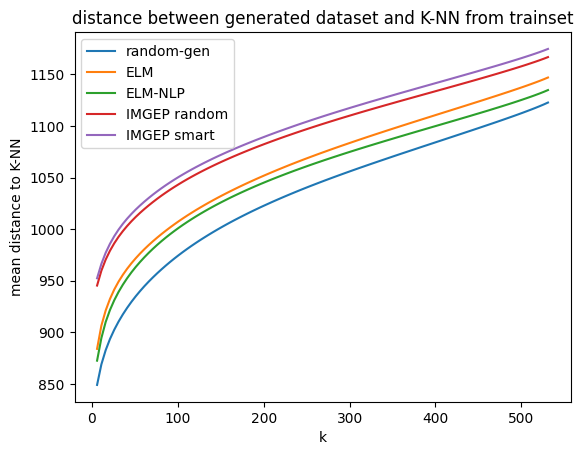

In [109]:
list_k= [i for i in range(1,len(_list_emb_trainset),5)]
for i in list_values:
    plt.plot(list_k,i)
plt.legend(list_legend)
plt.xlabel("k")
plt.ylabel("mean distance to K-NN")
plt.title("distance between generated dataset and K-NN from trainset")

In [118]:
path_maps=full_list_path_seed1[0]+"maps.pkl"
with open(path_maps, "rb") as f:
    maps = pickle.load(f)
allitems=getallitems(maps)
items_trainset = [item for item in allitems if item.idx_generation==-1]
items_gen = [item for item in allitems if item.idx_generation!=-1]
len(items_trainset), len(items_gen)

def skill_bool_2idx(skill_targeted):
    return [idx for idx, val in enumerate(skill_targeted) if val]


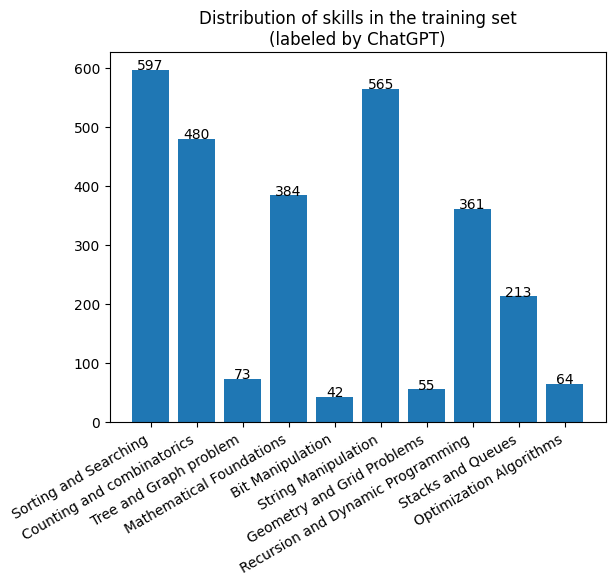

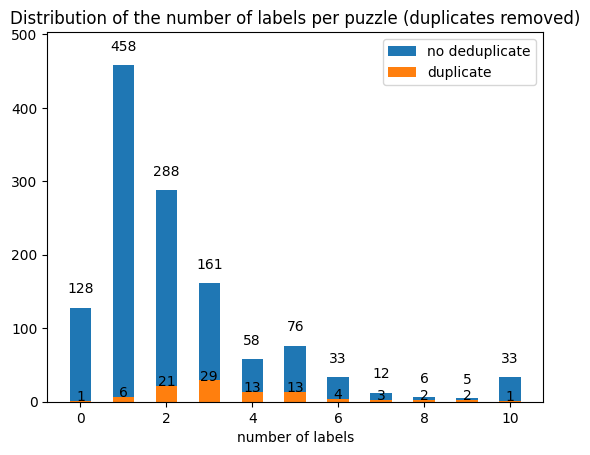

In [145]:

labels = [skill_bool_2idx(i.emb) for i in items_gen]
Label_predicted=labels
# m = [i["program_str"] for i in Labels]
#flatten the labels
labels_flatt = [item for sublist in labels for item in sublist]

# replace xaxis with categories name

categories = skill_list


plt.hist(labels_flatt, bins=range(0, 11), align='left', rwidth=0.8)

# Get the counts of each category
counts = [labels_flatt.count(i) for i in range(len(categories))]

# Add the counts as text on top of each bin
for i, count in enumerate(counts):
    if count > 0:
        plt.text(i, count + 0.85, str(count), ha='center')

# Set the x-axis tick locations and labels
plt.xticks(range(len(categories)), categories, rotation=30, ha='right')
plt.title("Distribution of skills in the training set\n(labeled by ChatGPT)")
# plt.savefig("distribution_labels.pdf")
plt.show()



set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
len_all_label=[len(i) for i in Label_predicted]
counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# plt.grid()
plt.title("Distribution of the number of labels per puzzle")
plt.xlabel("number of labels")
for i, count in enumerate(counts_n_label):
    # print(i)
    if count > 0:
        plt.text(i, count + 20., str(count), ha='center')
# plt.show()
ylim=max(counts_n_label)

set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
len_all_label=[len(i) for i in set_of_label_idx]
counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# plt.grid()
plt.title("Distribution of the number of labels per puzzle (duplicates removed)")
plt.xlabel("number of labels")
for i, count in enumerate(counts_n_label):
    # print(i)
    if count > 0:
        plt.text(i, count + 0.15, str(count), ha='center')
plt.ylim(top=ylim+45)
plt.legend(["no deduplicate","duplicate"])
plt.show()

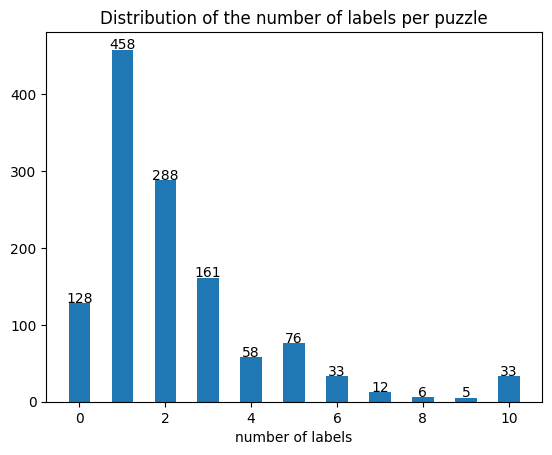

In [120]:
set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
len_all_label=[len(i) for i in Label_predicted]
counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# plt.grid()
plt.title("Distribution of the number of labels per puzzle")
plt.xlabel("number of labels")
for i, count in enumerate(counts_n_label):
    # print(i)
    if count > 0:
        plt.text(i, count + 0.95, str(count), ha='center')

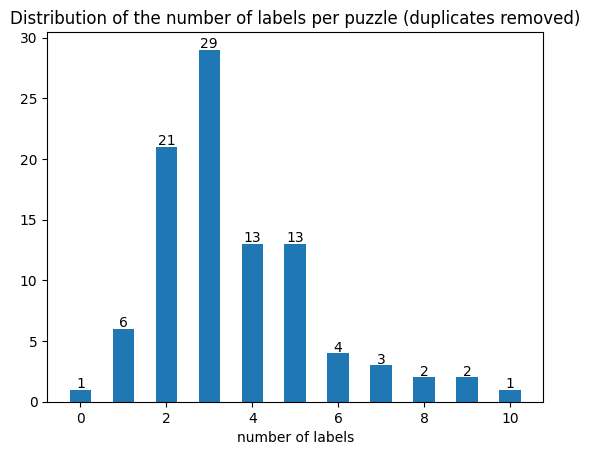

In [121]:
set_of_label_idx=[list(item) for item in set(tuple(row) for row in Label_predicted)]
len_all_label=[len(i) for i in set_of_label_idx]
counts_n_label = [len_all_label.count(i) for i in range(len(categories)+1)]
plt.hist(len_all_label,bins=range(0, np.max(len_all_label)+2),align='left', rwidth=0.5)
# plt.grid()
plt.title("Distribution of the number of labels per puzzle (duplicates removed)")
plt.xlabel("number of labels")
for i, count in enumerate(counts_n_label):
    # print(i)
    if count > 0:
        plt.text(i, count + 0.15, str(count), ha='center')